# Extracting The New Dataset
The new dataset consists of images collected from many different sources. There are X images per class.

In [ ]:
# link to Raisa's Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
file_dir = '/content/drive/MyDrive/Test/Final_Test_Dataset.zip'
extract_file_dir = '/content/drive/MyDrive/Test/Extracted_Data/'

import zipfile
with zipfile.ZipFile(file_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_file_dir)

In [ ]:
test_folder = '/content/drive/MyDrive/Test/Extracted_Data/content/Final_Test_Dataset'

#dekhi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Test/Final_Test_Dataset.zip', 'r') #raisa's path
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torchvision.models

In [ ]:
torch.manual_seed(1)

In [36]:
import torchvision.transforms as transforms
transform = transforms.Compose(
        [ #resize all images to height and width of 280
         transforms.ToTensor(),        #transform images to tensors
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

test_data = torchvision.datasets.ImageFolder("/tmp/content/Final_Test_Dataset", transform=transform)

print(test_data.class_to_idx)

import torch.utils.data
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=1)

print('There are', len(test_data), 'images in the test dataset.')

{'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6, 'platelet': 7}
There are 48 images in the test dataset.


# Final Model
Using the saved weights of our final model, we will carry out this testing

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 257MB/s]


In [ ]:
#only want the filter weights, not the classifier
convalexnet = alexnet.features

convalexnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
# Final model
class proposed2(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(proposed2, self).__init__()
        self.name = "Proposed2"
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.hidden_size = hidden_size
        self.fcCNN = nn.Linear(256*7*7, 60) #64*34*34 #192*16*16 #192*34*34
        self.fcRNN = nn.Linear(hidden_size, 60)
        self.fc = nn.Linear(60+60, num_class)

    def forward(self, x):
        cnnpath = convalexnet(x) #convgg16(x)
        x = torch.flatten(x, 2,3) #x.view(-1, 78400) #2352000?
        x = x.permute(1, 0, 2) 
        h0 = torch.zeros(1, len(x), self.hidden_size)
        #if use_cuda:
        h0=h0.to(device)
        rnnpath, __=self.rnn(x, h0)
        rnnpath = rnnpath[-1,:,:]
        cnnpath = torch.flatten(cnnpath, 1)

        cnnpath = F.relu(self.fcCNN(cnnpath))
        rnnpath = F.relu(self.fcRNN(rnnpath))

        merged = torch.cat((cnnpath, rnnpath),1)
        x = self.fc(merged)

        return x

In [21]:
input_size = 78400
hidden_size = 64 #this needs to be the hidden size of the model you chose
num_class = 8
demo_net = proposed2(input_size, hidden_size, num_class)
model_path = "/content/drive/MyDrive/Demo/model_h64_bs64_lr0.005_epoch7" # the path of the model you chose
state = torch.load(model_path)
demo_net.load_state_dict(state)

<All keys matched successfully>

In [22]:
use_cuda = True
device = "cuda"
demo_net.to(device)
convalexnet.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# Testing on the New Dataset
In this section we will be inputting our new dataset image into our final model and outputting the ground truth label, predicted label, and the picture.

lymphocyte -> neutrophil


In [23]:
trained_on_classes = ['basophil', 'neutrophil', 'ig', 'monocyte', 
               'eosinophil', 'erythroblast', 'lymphocyte', 'platelet']

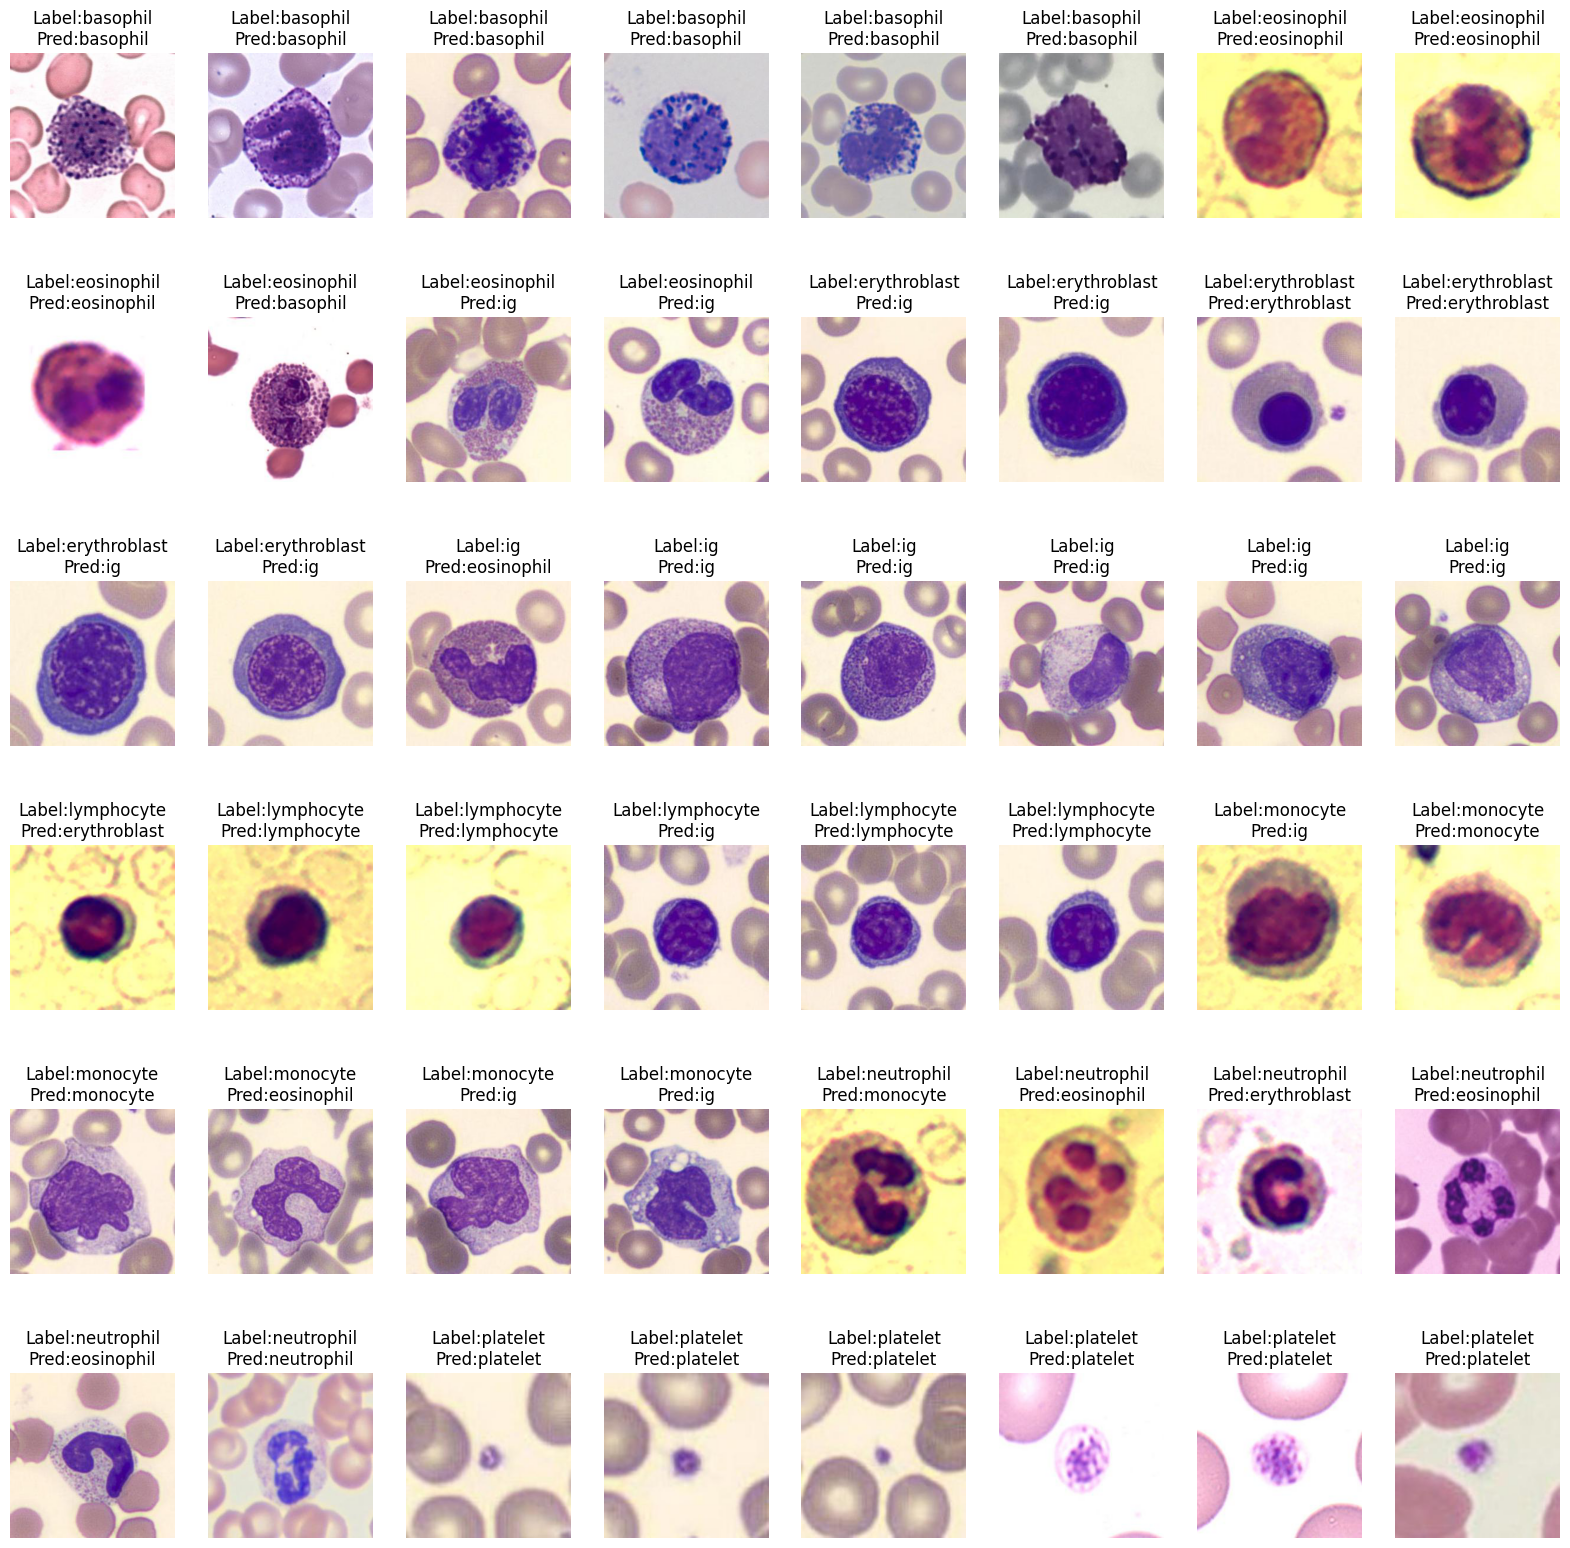

In [37]:
import numpy as np
import matplotlib.pyplot as plt

n = 0
for image, label in test_loader:

  if use_cuda and torch.cuda.is_available():
              image = image.cuda()
              label = label.cuda()

  single_output = demo_net(image)     #generate an array of probabilities for each class
  pred = single_output.max(1, keepdim=True)[1]  #determine the class that is predicted

  plt.subplot(6, 8, n+1)
  img = image.cpu()[0]
  imgx = np.transpose(img, [1,2,0])
  imgx = imgx / 2 + 0.5   #normalize values
  plt.rcParams['figure.figsize'] = [20,20]    #resize
  plt.imshow(imgx)
  plt.axis('off')
  plt.title('Label:' + classes[label[0]] + '\nPred:' + classes[pred[0]])

  n = n + 1

  #if n > 14:
  # break

In [38]:
def get_accuracy(model, data):
    correct = 0
    total = 0

    for imgs, labels in data:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
          
        #############################################
        #print("here",imgs.shape)
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1] #idk if model will give probability of the classes or what
        correct += pred.eq(labels.view_as(pred)).sum().item() #do we need to apply soft max??
        total += imgs.shape[0]
    return correct / total

In [39]:
get_accuracy(demo_net, test_loader)

0.6041666666666666